In [1]:
import xspec
import numpy as np
import matplotlib.pyplot as plot
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
cd

/home/abhi


In [3]:
cd Desktop/spa635m/ER/

/home/abhi/Desktop/spa635m/ER


In [4]:
ls

'1eRASS J052115.9+251331'/     '1eRASS J160725.5-144528.tar'   powfiles
'1eRASS J052115.9+251331.tar'   analysis/
'1eRASS J160725.5-144528'/      make_pha_files*


In [5]:
cd '1eRASS J160725.5-144528'/

/home/abhi/Desktop/spa635m/ER/1eRASS J160725.5-144528


In [11]:
xspec.AllData("SS_IB.pi")
#xspec.AllData.ignore("**-0.1 10-**")
xspec.Plot("data")
xspec.Plot.xAxis = "keV"

x_values = xspec.Plot.x()
y_values = xspec.Plot.y()
y_error = np.array(xspec.Plot.yErr())
x_error = np.array(xspec.Plot.xErr())


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: SS_IB.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.862e-01 +/- 4.880e-02 (89.9 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-407
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 227.3 sec
 Using fit statistic: chi
 Using Background File                ./em01_242105_020_BackgrSpec_00002_c010.fits
  Background Exposure Time: 227.3 sec
 Using Response (RMF) File            ./em01_242105_020_RMF_00002_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_242105_020_ARF_00002_c010.fits



Text(0.5, 1.0, 'SS-IB X-ray Source')

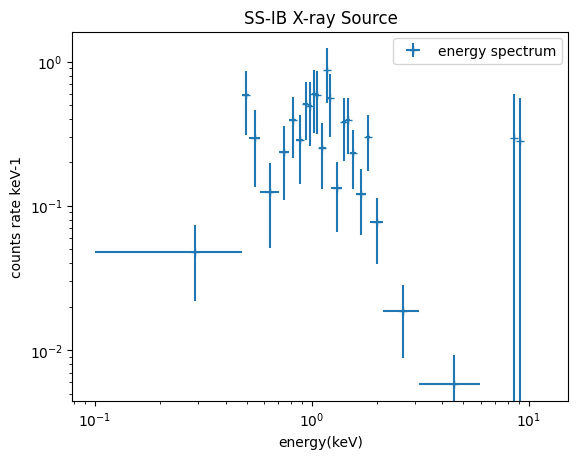

In [12]:
plot.errorbar(x_values,y_values,xerr = x_error, yerr = y_error, fmt="+", label = "energy spectrum")
plot.xscale("log")
plot.yscale("log")
plot.xlabel("energy(keV)")
plot.ylabel("counts rate keV-1")
plot.legend()
plot.title("SS-IB X-ray Source")

In [13]:
#Column Stacking X and Removing negative and zero counts
x = np.log10(x_values)
y = y_values

X1 = np.column_stack((x,y))
X = []
for i in X1:
    if i[-1] != 0 and np.all(i > 0):  
        X.append(i)
        #y_val = np.array(y_val)
X= np.array(X)

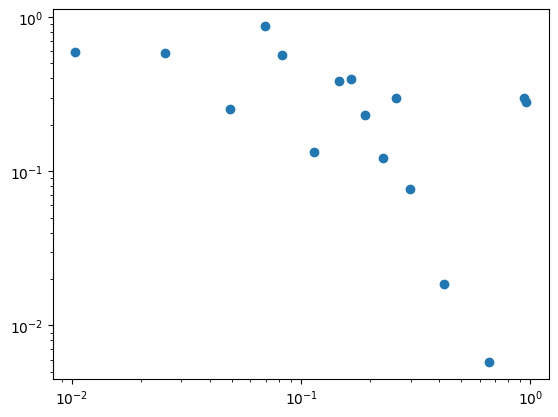

In [14]:
#Plotting the final plot
energy =  X[:,0]
counts = X[:,1]
plot.scatter(energy,counts)
plot.xscale("log")
plot.yscale("log")

In [15]:
##Doing interpolation to find Ep through minimization 
f = interp1d(energy,counts, kind = "cubic", fill_value="extrapolate")

def f1(x):
    if energy.min() <= x <= energy.max():  
        return -f(x)

Ep = minimize(f1,x0 = 0.09,method = "Nelder-Mead").x[0]
Cp = f(Ep)
Ep, Cp

(0.06975000000000003, array(0.87422727))

In [16]:
#Fitting model (broken Power law) and initial parameters
model = xspec.Model("bknpower")
xspec.AllData.ignore("**-0.2 3.0-**")

#initiate params
model.bknpower.PhoIndx1 = 1
model.bknpower.BreakE = 1
model.bknpower.PhoIndx2 = 2
model.bknpower.norm = 1


Model bknpower<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   bknpower   PhoIndx1            1.00000      +/-  0.0          
   2    1   bknpower   BreakE     keV      5.00000      +/-  0.0          
   3    1   bknpower   PhoIndx2            2.00000      +/-  0.0          
   4    1   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              2.033457e+09     using 407 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared              2.033457e+09     using 407 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 403 degrees of freedom
 Current data and model not fit yet.
     1 channels (1) ignored in spectrum # 

In [17]:
#Fitting
xspec.Fit.perform()

                                   Parameters
Chi-Squared  |beta|/N    Lvl    1:PhoIndx1      2:BreakE    3:PhoIndx2        4:norm
21.0275      2.28579      -3     0.0760612       1.15037       1.85158   0.000327190
19.6233      5322.82      -1     -0.118057      0.983509       1.60415   0.000335220
19.305       1440.22      -2     -0.484202       1.01676       1.89169   0.000367304
19.2255      502.585      -1     -0.625482      0.978911       1.85172   0.000383897
19.2063      479.316      -2     -0.677214      0.993779       1.93063   0.000387030
19.1977      47.8532      -1     -0.719928      0.983349       1.91125   0.000392895
 Variances and Principal Axes
                 1        2        3        4  
 2.0854E-09|  0.0000   0.0007  -0.0001   1.0000  
 9.5417E-03|  0.0964  -0.9867   0.1306   0.0007  
 6.0704E-01| -0.0867   0.1224   0.9887   0.0000  
 1.9140E+00|  0.9916   0.1066   0.0737  -0.0001  
--------------------------------------------------

  Covariance Matrix
        1

In [18]:
# Print parameter values
print("Photon Index1:", model.bknpower.PhoIndx1.values[0])
print("Photon Index2:", model.bknpower.PhoIndx2.values[0])
print("Ep:",model.bknpower.BreakE.values[0])

Photon Index1: -0.7199279596229724
Photon Index2: 1.9112455225239748
Ep: 0.9833492235370843


In [21]:
#Plotting
xspec.Plot.xLog = True
xspec.Plot.yLog = True
xspec.Plot.add = True  
xspec.Plot.device = "/xs"  
xspec.Plot("uf delc")